In [2]:
import numpy as np

data = np.load("path_to_save/plotting_data.npz")

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim

import torch
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms

In [ ]:
# --- Cleaned Plotting Utilities ---
def plot_histogram(ax, metric_low, metric_high, title, xlabel):
    sns.histplot(
        metric_low,
        bins=50,
        color="blue",
        label="Low Eps",
        stat="density",
        kde=True,
        ax=ax,
    )
    sns.histplot(
        metric_high,
        bins=50,
        color="red",
        label="High Eps",
        stat="density",
        kde=True,
        ax=ax,
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True)


def plot_boxplot(ax, metric_low, metric_high, title):
    data = {
        "Value": np.concatenate([metric_low, metric_high]),
        "Attack": ["Low Eps"] * len(metric_low) + ["High Eps"] * len(metric_high),
    }
    sns.boxplot(x="Attack", y="Value", data=data, ax=ax)
    ax.set_title(title)
    ax.grid(True)


def plot_cdf(ax, metric_low, metric_high, title, xlabel):
    sns.ecdfplot(metric_low, label="Low Eps", color="blue", ax=ax)
    sns.ecdfplot(metric_high, label="High Eps", color="red", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Cumulative Probability")
    ax.legend()
    ax.grid(True)


def plot_ssim_distribution(ax, clean_images, low_eps_images, high_eps_images, title):
    # List to store SSIM values
    ssim_values_low = []
    ssim_values_high = []

    # Compute SSIM for both low and high epsilon images
    for i in range(clean_images.size(0)):
        clean_img = clean_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC
        low_eps_img = (
            low_eps_images[i].permute(1, 2, 0).cpu().numpy()
        )  # Convert to HxWxC
        high_eps_img = (
            high_eps_images[i].permute(1, 2, 0).cpu().numpy()
        )  # Convert to HxWxC

        # Calculate SSIM with data_range set to 1 (assuming images are [0, 1] range)
        ssim_index_low = ssim(clean_img, low_eps_img, channel_axis=-1, data_range=1)
        ssim_index_high = ssim(clean_img, high_eps_img, channel_axis=-1, data_range=1)

        # Append SSIM values for both low and high epsilon perturbations
        ssim_values_low.append(ssim_index_low)
        ssim_values_high.append(ssim_index_high)

    # Plot SSIM values for low epsilon perturbation
    sns.histplot(
        ssim_values_low, bins=50, kde=True, color="blue", label="Low Epsilon", ax=ax
    )

    # Plot SSIM values for high epsilon perturbation
    sns.histplot(
        ssim_values_high, bins=50, kde=True, color="red", label="High Epsilon", ax=ax
    )

    # Set plot labels and title
    ax.set_title(f"{title} - SSIM Distribution")
    ax.set_xlabel("SSIM")
    ax.set_ylabel("Frequency")
    ax.grid(True)
    ax.legend()


def plot_difference_heatmap(ax, clean_images, adv_images, title):
    diff = torch.abs(clean_images - adv_images).mean(dim=0).cpu()  # Average over batch
    diff_img = diff.permute(1, 2, 0).numpy()
    im = ax.imshow(diff_img, cmap="hot")
    ax.set_title(title)
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


def plot_perturbation_norms(ax, clean_images, low_eps_images, high_eps_images, title):
    # Compute L2 norms for both low and high epsilon perturbations
    perturbations_low = (low_eps_images - clean_images).view(low_eps_images.size(0), -1)
    perturbations_high = (high_eps_images - clean_images).view(
        high_eps_images.size(0), -1
    )

    # L2 norm of perturbations for both low and high epsilon perturbations
    norms_low = torch.norm(perturbations_low, dim=1).cpu().numpy()
    norms_high = torch.norm(perturbations_high, dim=1).cpu().numpy()

    # Plot perturbation norms for low epsilon perturbation
    sns.histplot(norms_low, bins=50, kde=True, color="blue", label="Low Epsilon", ax=ax)

    # Plot perturbation norms for high epsilon perturbation
    sns.histplot(
        norms_high, bins=50, kde=True, color="red", label="High Epsilon", ax=ax
    )

    # Set plot labels and title
    ax.set_title(f"{title} - Perturbation Norms")
    ax.set_xlabel("L2 Norm")
    ax.set_ylabel("Frequency")
    ax.grid(True)
    ax.legend()


def plot_flip_rate_bars(data, ax):
    variants = ["normal", "mask", "mask_plus_random"]
    labels = {
        "normal": "Adversarial",
        "mask": "Mask Only",
        "mask_plus_random": "Mask + Random",
    }

    low_flip_rates = []
    high_flip_rates = []
    variant_labels = []

    for variant in variants:
        low_key = f"flip_low_{variant}"
        high_key = f"flip_high_{variant}"

        if low_key in data and high_key in data:
            flip_low = data[low_key]
            flip_high = data[high_key]

            flip_rate_low = flip_low.mean() * 100  # as percentage
            flip_rate_high = flip_high.mean() * 100

            low_flip_rates.append(flip_rate_low)
            high_flip_rates.append(flip_rate_high)
            variant_labels.append(labels[variant])
        else:
            print(f"Warning: Missing flip data for variant '{variant}'")

    x = np.arange(len(variant_labels))  # label locations
    width = 0.35  # bar width

    # Updated color scheme: Blue for Low Epsilon, Red for High Epsilon
    ax.bar(x - width / 2, low_flip_rates, width, label="Low Epsilon", color="blue")
    ax.bar(x + width / 2, high_flip_rates, width, label="High Epsilon", color="red")

    ax.set_ylabel("Flip Rate (%)")
    ax.set_xlabel("Perturbation Type")
    ax.set_title("Label Flip Rates Across Attacks")
    ax.set_xticks(x)
    ax.set_xticklabels(variant_labels)
    ax.legend()
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)

    ax.set_ylim(0, 100)  # Ensure the y-axis spans 0-100%
    ax.set_xticks(x)



# --- Full Panel Per Variant ---
def plot_full_panel(
    data, variant_suffix, label, clean_images, low_eps_images, high_eps_images
):
    metrics = ["kl", "tvd", "conf_drop"]
    titles = {
        "kl": "KL Divergence",
        "tvd": "Total Variation Distance",
        "conf_drop": "Confidence Drop",
    }

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        low_key = f"{metric}_low{variant_suffix}"
        high_key = f"{metric}_high{variant_suffix}"

        # Check if both low and high keys exist in data and plot them
        if low_key in data and high_key in data:
            plot_histogram(
                axes[idx],  # Axes for this plot
                data[low_key],  # Data for low epsilon
                data[high_key],  # Data for high epsilon
                f"{titles[metric]} ({label})",  # Title
                titles[metric],  # Metric name
            )
        else:
            axes[idx].axis("off")  # Hide axis if data is missing

    # Last row: SSIM distribution, Perturbation Norms, Flip Rate Bar Graph
    plot_ssim_distribution(
        axes[3], clean_images, low_eps_images, high_eps_images, f"SSIM Distribution ({label})"
    )
    plot_perturbation_norms(
        axes[4],
        clean_images,
        low_eps_images,
        high_eps_images,
        f"Perturbation Norms ({label})",
    )
    plot_flip_rate_bars(
        data, axes[5]
    ) 
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to fit the title
    plt.show()

In [10]:
# Load npz file
npz_data = np.load("path_to_save/plotting_data.npz")

# Load .pt image files
low_eps_images = torch.load("path_to_save/normal_low_dataset/data.pt")
high_eps_images = torch.load("path_to_save/normal_high_dataset/data.pt")
low_eps_mask = torch.load("path_to_save/mask_low_dataset/data.pt")
high_eps_mask = torch.load("path_to_save/mask_high_dataset/data.pt")
low_eps_mask_plus_random = torch.load("path_to_save/mask_plus_random_low_dataset/data.pt")
high_eps_mask_plus_random = torch.load(
    "path_to_save/mask_plus_random_high_dataset/data.pt"
)

# Wrap loaded .pt tensors in a dict for easier access
image_data = {
    "normal": (low_eps_images, high_eps_images),
    "mask": (low_eps_mask, high_eps_mask),
    "mask_plus_random": (low_eps_mask_plus_random, high_eps_mask_plus_random),
}

In [5]:
high_eps_images.shape

torch.Size([60000, 3, 32, 32])

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # [0, 1]
    ]
)
# Load both train and test splits
cifar10_train = datasets.CIFAR10(
    root="path/to/cifar10", train=True, download=True, transform=transform
)
cifar10_test = datasets.CIFAR10(
    root="path/to/cifar10", train=False, download=True, transform=transform
)

# Concatenate them
cifar10_full = ConcatDataset([cifar10_train, cifar10_test])

# Stack into one tensor
clean_images = torch.stack([img for img, _ in cifar10_full])

print(f"Loaded {clean_images.shape[0]} clean CIFAR-10 images.")  # Should print 60000

Loaded 60000 clean CIFAR-10 images.


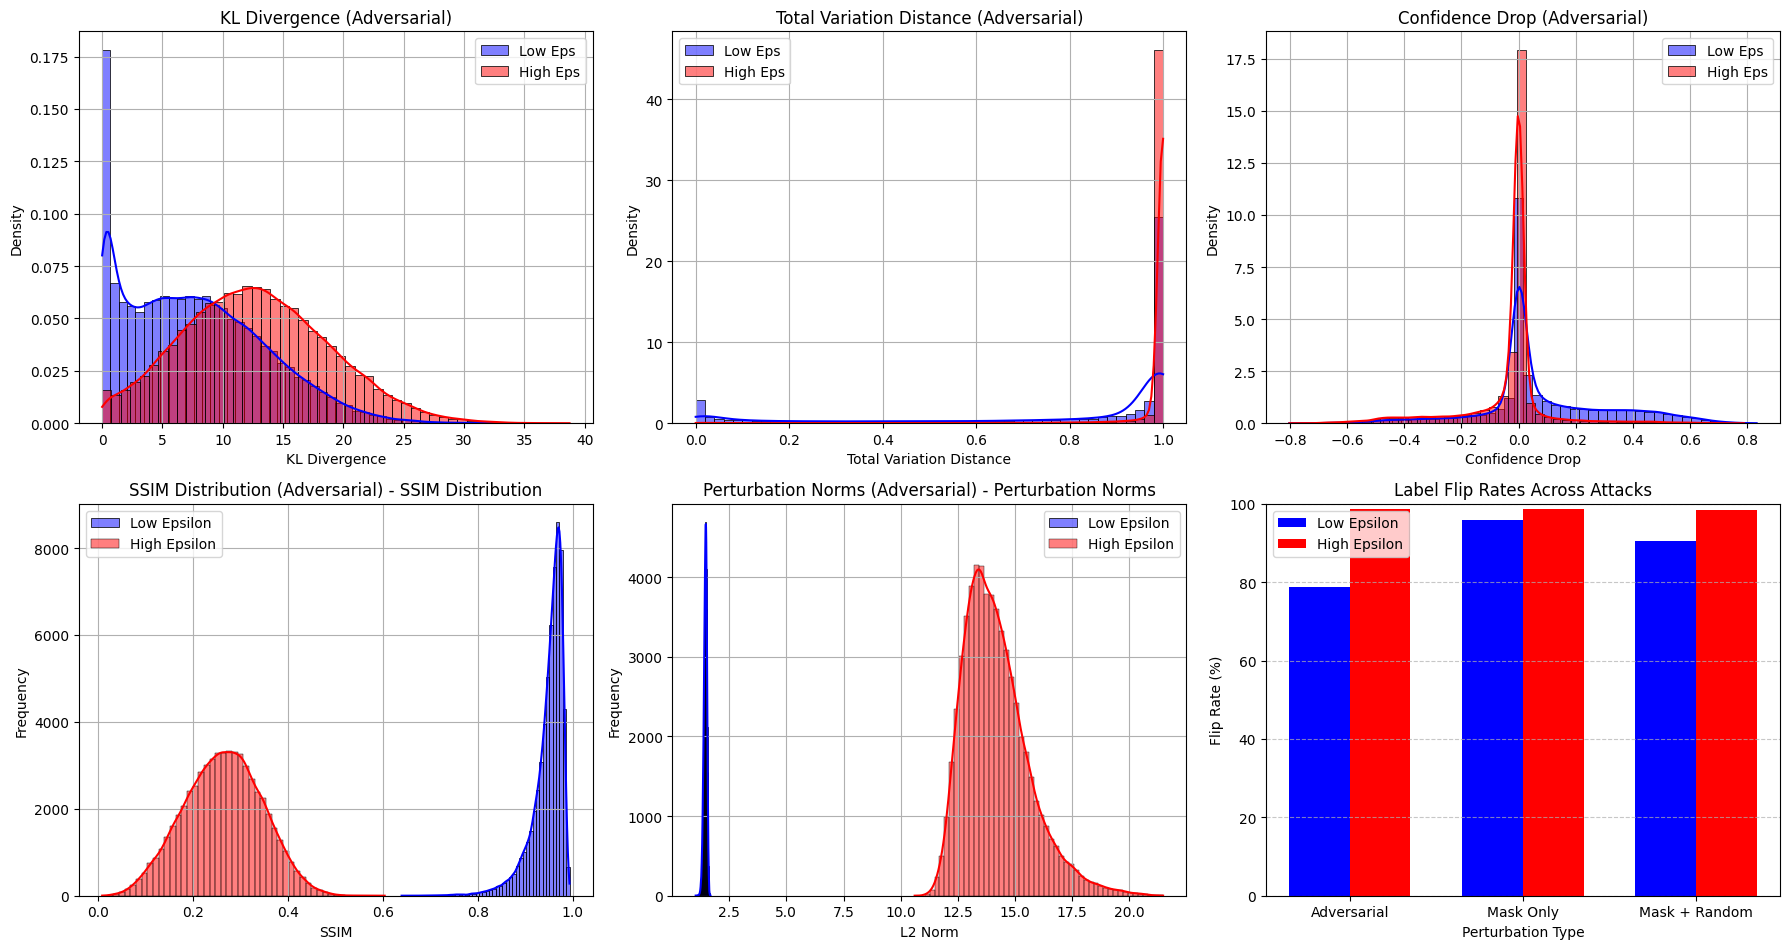

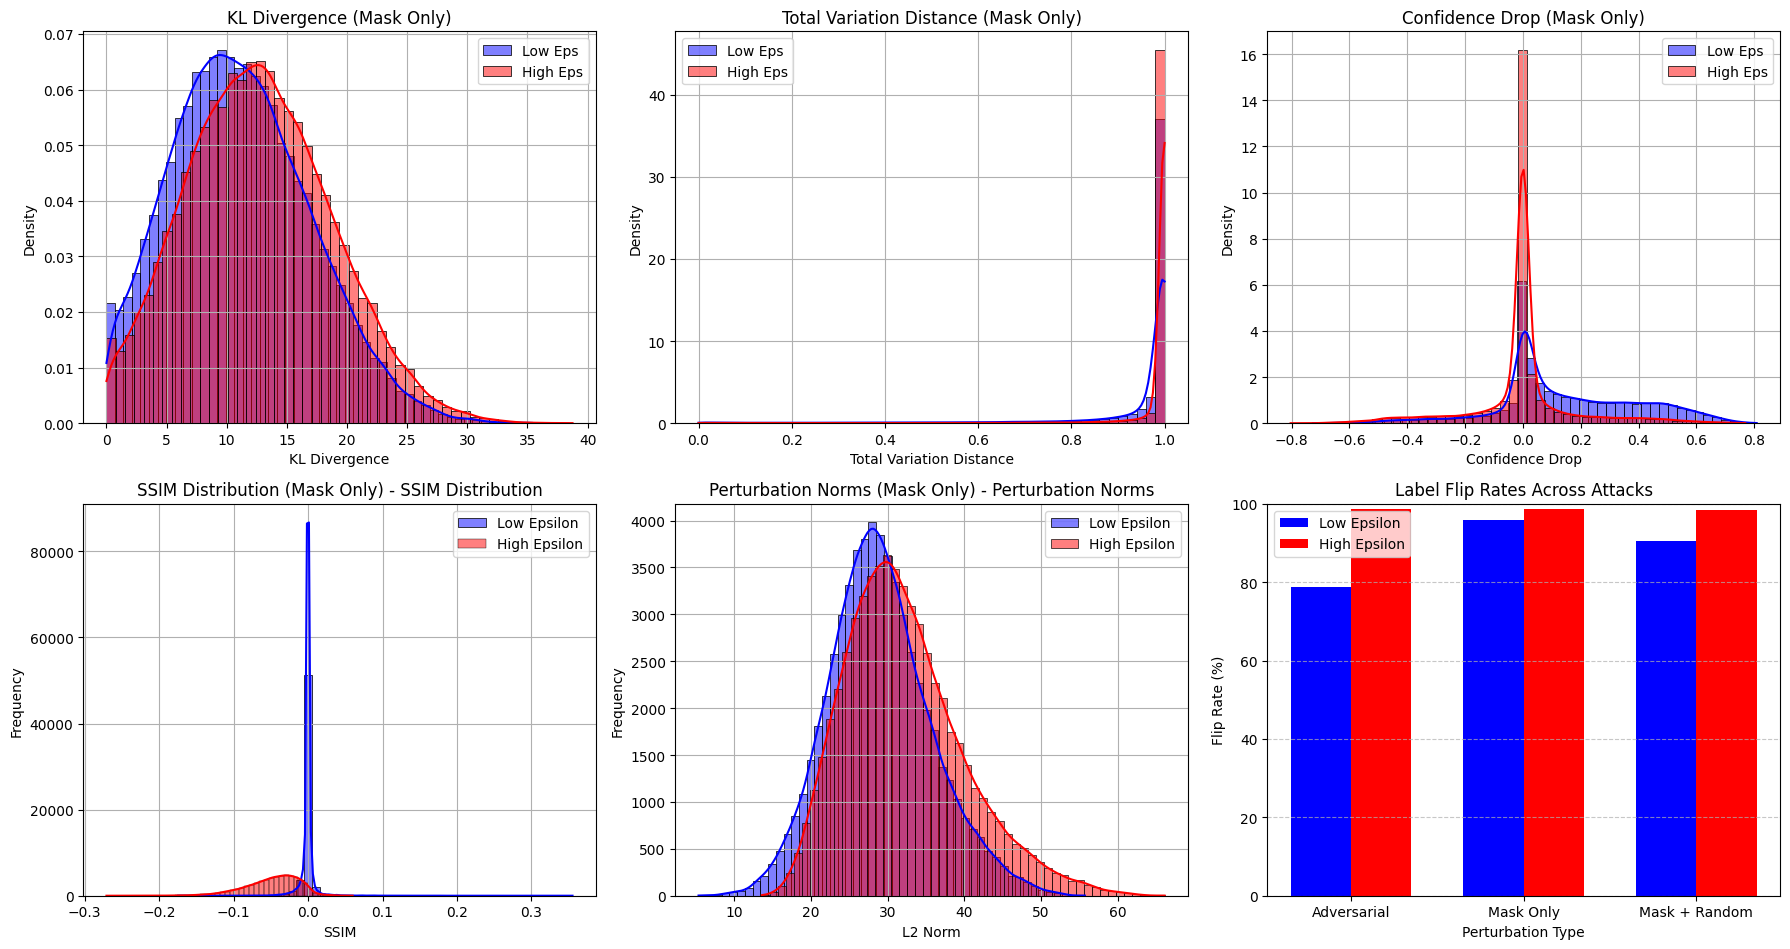

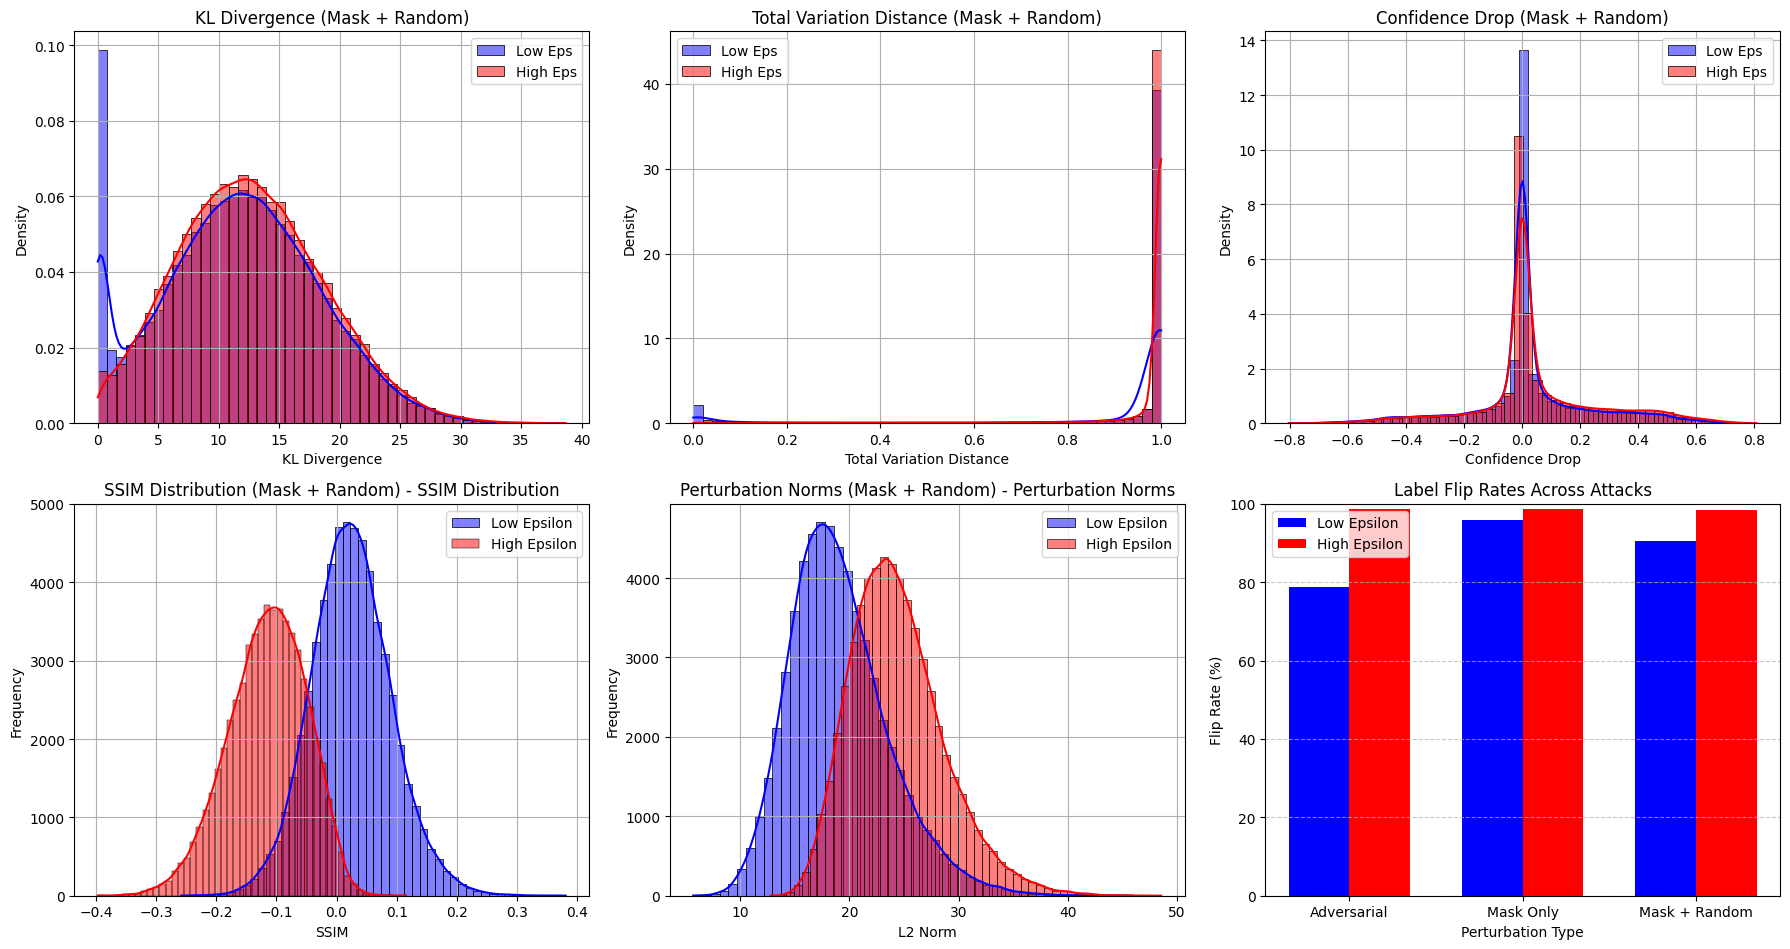

In [17]:
# Map metric suffixes and labels
variants = ["normal", "mask", "mask_plus_random"]
labels = {
    "normal": "Adversarial",
    "mask": "Mask Only",
    "mask_plus_random": "Mask + Random"
}

for variant in variants:
    low_eps_images, high_eps_images = image_data[variant]

    plot_full_panel(
        data=npz_data,
        variant_suffix=f"_{variant}",
        label=labels[variant],
        clean_images=clean_images,
        low_eps_images=low_eps_images,
        high_eps_images=high_eps_images,
    )